Installing packages

In [2]:
# Install Packages
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

     |████████████████████████████████| 2.0MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


Importing packages

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Setting up seeds

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

Model (CNN)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Training Function

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
    return losses

Validation Function

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

Loading Data

In [0]:
def load_data(train_batch_size=128, valid_batch_size = 1000):
    mnist_mean = 0.1307
    mnist_stddev = 0.3081
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                    train=True,
                    download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((mnist_mean,), (mnist_stddev,))
                    ])),
        batch_size=train_batch_size,
        shuffle=True)

    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((mnist_mean,), (mnist_stddev,))
                    ])),
        batch_size=valid_batch_size,
        shuffle=True)
    
    return train_loader, valid_loader

In [9]:
train_loader,valid_loader=load_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21702887.05it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 331771.39it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5279169.86it/s]                           
8192it [00:00, 131564.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Training

In [0]:
import time

now = time.time()

In [11]:
time.time()-now

0.3361184597015381

In [0]:
def test_hyperparamater(num_epochs, model, device, train_loader, valid_loader, optimizer):
    train_losses = []
    valid_losses = []
    valid_x = []
    now = time.time()
    for epoch in range(1, num_epochs + 1):
        epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
        train_losses.extend(epoch_losses)
        valid_loss = validate(model, device, valid_loader)
        valid_losses.append([valid_loss])
        valid_x.append(len(train_losses) - 1)
    
    return valid_losses, train_losses, time.time()-now

#### Testing **test_hyperparameter**

In [13]:
num_epochs = 10
learning_rate = [0.01, 0.02, 0.1, 0.3]
validation_graphs = np.zeros([len(learning_rate), num_epochs])
elapsed_time = np.zeros([len(learning_rate), 1])

for i in range(len(learning_rate)):
    print("Learning Rate: ", learning_rate[i])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate[i], momentum=0.5) # NEED TO CHANGE LEARNING RATE

    valid_losses, train_losses, time_ = test_hyperparamater(num_epochs, model, device, train_loader, valid_loader, optimizer)

    validation_graphs[i,:] = np.array(valid_losses).squeeze()
    elapsed_time[i] = time.time()-now
    print(elapsed_time[i])

Learning Rate:  0.01

Validation set: Average loss: 0.1658, Accuracy: 9497/10000 (95%)


Validation set: Average loss: 0.0959, Accuracy: 9709/10000 (97%)


Validation set: Average loss: 0.0696, Accuracy: 9791/10000 (98%)


Validation set: Average loss: 0.0557, Accuracy: 9820/10000 (98%)


Validation set: Average loss: 0.0482, Accuracy: 9846/10000 (98%)


Validation set: Average loss: 0.0521, Accuracy: 9823/10000 (98%)


Validation set: Average loss: 0.0442, Accuracy: 9850/10000 (98%)


Validation set: Average loss: 0.0409, Accuracy: 9867/10000 (99%)


Validation set: Average loss: 0.0373, Accuracy: 9876/10000 (99%)


Validation set: Average loss: 0.0345, Accuracy: 9874/10000 (99%)

[116.89176321]
Learning Rate:  0.02

Validation set: Average loss: 0.1139, Accuracy: 9633/10000 (96%)


Validation set: Average loss: 0.0555, Accuracy: 9827/10000 (98%)


Validation set: Average loss: 0.0452, Accuracy: 9858/10000 (99%)


Validation set: Average loss: 0.0416, Accuracy: 9866/10000 (99%)


Vali

In [14]:
num_epochs = 10
learning_rate = [0.005, 0.01, 0.02, 0.1, 0.15, 0.5]
validation_graphs = np.zeros([len(learning_rate), num_epochs])
elapsed_time = np.zeros([len(learning_rate), 1])

for i in range(len(learning_rate)):
    print("Learning Rate: ", learning_rate[i])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate[i], momentum=0.5) # NEED TO CHANGE LEARNING RATE

    train_losses = []
    valid_losses = []
    valid_x = []
    now = time.time()
    for epoch in range(1, num_epochs + 1):
        epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
        print(epoch_losses)
        train_losses.extend(epoch_losses)
        valid_loss = validate(model, device, valid_loader)
        valid_losses.append([valid_loss])
        valid_x.append(len(train_losses) - 1)

    validation_graphs[i,:] = np.array(valid_losses).squeeze()
    elapsed_time[i] = time.time()-now
    print(elapsed_time[i])

Learning Rate:  0.005
[2.3206920623779297, 2.319160223007202, 2.3093857765197754, 2.3011021614074707, 2.301353931427002, 2.2886836528778076, 2.2973008155822754, 2.282729148864746, 2.2889034748077393, 2.289823293685913, 2.290189504623413, 2.296663999557495, 2.2823598384857178, 2.2687346935272217, 2.2929434776306152, 2.2801811695098877, 2.2723662853240967, 2.2685728073120117, 2.26585054397583, 2.264594078063965, 2.2542901039123535, 2.257037401199341, 2.2473466396331787, 2.2674002647399902, 2.2456412315368652, 2.2595996856689453, 2.2416815757751465, 2.259697198867798, 2.2374050617218018, 2.237842082977295, 2.224052667617798, 2.2196404933929443, 2.236628770828247, 2.230581283569336, 2.2288308143615723, 2.2261741161346436, 2.227099657058716, 2.229046106338501, 2.220453977584839, 2.2143373489379883, 2.21541690826416, 2.1908795833587646, 2.202674388885498, 2.202589273452759, 2.2083184719085693, 2.201272964477539, 2.181939125061035, 2.1658661365509033, 2.1743619441986084, 2.1848738193511963, 2

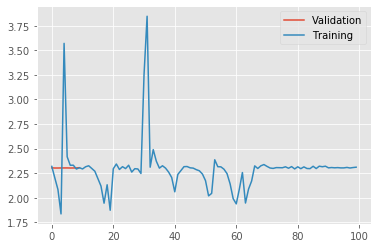

In [15]:
plt.style.use('ggplot')

plt.plot(valid_losses[0:100])
plt.plot(train_losses[0:100])
plt.legend(["Validation", "Training"])
plt.show()

In [16]:
train_losses

[2.318488597869873,
 2.1993327140808105,
 2.0829854011535645,
 1.8348358869552612,
 3.57069730758667,
 2.4164345264434814,
 2.330043077468872,
 2.3304851055145264,
 2.2917537689208984,
 2.305076837539673,
 2.2923595905303955,
 2.314798355102539,
 2.3248658180236816,
 2.2975106239318848,
 2.269242286682129,
 2.193948984146118,
 2.118277072906494,
 1.9439677000045776,
 2.13149356842041,
 1.8721493482589722,
 2.294306755065918,
 2.3427786827087402,
 2.2872602939605713,
 2.315673589706421,
 2.2960283756256104,
 2.330430030822754,
 2.260713577270508,
 2.2950191497802734,
 2.2923457622528076,
 2.246255874633789,
 3.249783754348755,
 3.8466460704803467,
 2.310312032699585,
 2.4891185760498047,
 2.37174129486084,
 2.3008174896240234,
 2.3249666690826416,
 2.300853967666626,
 2.2605581283569336,
 2.205151081085205,
 2.0598392486572266,
 2.2369439601898193,
 2.2758572101593018,
 2.315825939178467,
 2.31722092628479,
 2.3038675785064697,
 2.3009042739868164,
 2.285377025604248,
 2.273765563964843

In [17]:
elapsed_time

array([[105.33665085],
       [104.9868238 ],
       [105.20718431],
       [105.74706244],
       [104.95986319],
       [104.58747053]])

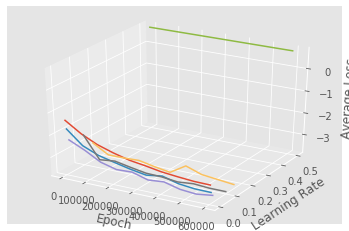

In [18]:
%matplotlib inline

plt.style.use('ggplot')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, num_epochs*6e4, num_epochs)
for i in range(len(learning_rate)):
    ax.plot(x, learning_rate[i]*np.ones([1,num_epochs]).squeeze(), np.log(validation_graphs[i,:]))

ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_zlabel("Average Loss")

plt.show()

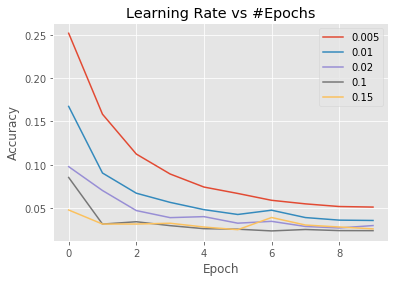

In [19]:
for i in range(len(learning_rate)-1):
    plt.plot(validation_graphs[i,:])
plt.title("Learning Rate vs #Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend([str(lr) for lr in learning_rate])
plt.show()

# Batch Size & Learning Rate


In [20]:
num_epochs = 10
learning_rate =[0.15] #[0.05, 0.1, 0.15, 0.5]
batch_size = [50,500, 30000, 60000]
validation_graphs = np.zeros([len(learning_rate), len(batch_size), num_epochs])
elapsed_time = np.zeros([len(learning_rate),len(batch_size), 1])

for j in range(len(batch_size)):
    train_loader, valid_loader = load_data(train_batch_size=batch_size[j], valid_batch_size=1000)
    print("Batch Size: ", batch_size[j])

    for i in range(len(learning_rate)):
        print("Learning Rate: ", learning_rate[i])
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = Net().to(device)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate[i], momentum=0.5) # NEED TO CHANGE LEARNING RATE

        valid_losses, train_losses, time_ = test_hyperparamater(num_epochs, model, device, train_loader, valid_loader, optimizer)

        validation_graphs[i,j,:] = np.array(valid_losses).squeeze()
        elapsed_time[i,j] = time.time()-now
        print(elapsed_time[i])

Batch Size:  50
Learning Rate:  0.15

Validation set: Average loss: 0.0344, Accuracy: 9891/10000 (99%)


Validation set: Average loss: 0.0467, Accuracy: 9854/10000 (99%)


Validation set: Average loss: 0.0363, Accuracy: 9879/10000 (99%)


Validation set: Average loss: 0.0290, Accuracy: 9919/10000 (99%)


Validation set: Average loss: 0.0331, Accuracy: 9901/10000 (99%)


Validation set: Average loss: 0.0411, Accuracy: 9888/10000 (99%)


Validation set: Average loss: 0.0315, Accuracy: 9898/10000 (99%)


Validation set: Average loss: 0.0317, Accuracy: 9915/10000 (99%)


Validation set: Average loss: 0.0450, Accuracy: 9886/10000 (99%)


Validation set: Average loss: 0.0445, Accuracy: 9891/10000 (99%)

[[225.88390326]
 [  0.        ]
 [  0.        ]
 [  0.        ]]
Batch Size:  500
Learning Rate:  0.15

Validation set: Average loss: 0.0959, Accuracy: 9694/10000 (97%)


Validation set: Average loss: 0.0650, Accuracy: 9790/10000 (98%)


Validation set: Average loss: 0.0460, Accuracy: 9855/10

In [21]:
 validation_graphs[0,i, :]

array([0.03442918, 0.04668682, 0.03628614, 0.02903269, 0.03307956,
       0.04114417, 0.03152943, 0.03166438, 0.0449896 , 0.04452904])

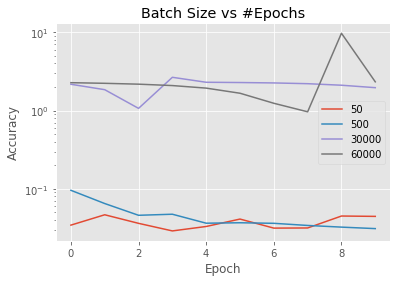

In [22]:
for i in range(len(batch_size)):
    plt.plot(validation_graphs[0,i,:])
    plt.yscale('log')
plt.title("Batch Size vs #Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend([str(bs) for bs in batch_size])
plt.show()